# AVO class 4 reference values

A little investigation on the reliability of the values given in "Principles of AVO crossplotting", Castagna et al., 1997, The Leading Edge.



In [33]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def bulk(vp, vs, rho):
    '''
    Calculate bulk modulus.
    (aadm 2017)

    Parameters
    ----------
    vp, vs: float
        P- and S-wave velocity [m/s].
    rho: float
        Density [g/cm3].

    Returns
    -------
    K: float
        Bulk modulus [GPa].
    '''
    # converts density to SI (kg/m3)
    D = rho*1e3
    K = D*vp**2 - 4/3*D*vs**2
    return K/1e9

def toyfrm(vp, vs, rho, phi, fluid, k0=37):
    '''
    toyfrm (C) aadm 2016-2020
    Computes fluid replacement on single-point brine sand defined only by vp, vs, rho and phi.
    '''
    rhob, kb = 1.0,  2.20
    if fluid == 'gas':
        rhof, kf = 0.1,  0.02 # rho gas Hilterman = 0.4
    else:
        rhof, kf = 0.80,  1.02
    vp2, vs2, rho2, *_ = squit.rp.gassmann(vp, vs, rho, rhob, kb, rhof, kf, k0, phi)
    return vp2, vs2, rho2

def gassmann_phi(ksat1, ksat2, kf1, kf2, kmin):
    a = (kmin-ksat1)*(kmin-ksat2)*(kf1-kf2) 
    b = (kmin-kf1)*(kmin-kf2)*(ksat1-ksat2)
    return a / b

def percdiff(start, end):
    return (end-start)/start

In the next cell block I define a function to calculate the reflectivity with the Shuey equation and an helper function to plot points in the Intercept-Gradient domain:

In [29]:

def shuey(vp1, vs1, rho1, vp2, vs2, rho2, theta, approx=True, terms=False):
    '''
    Calculate P-wave reflectivity with Shuey's equation.
    (aadm 2016, 2020)

    Parameters
    ----------
    vp1, vs1, rho1 : float or array_like
        P-, S-wave velocity (m/s) and density (g/cm3) of upper medium.
    vp2, vs2, rho2 : float or array_like
        P-, S-wave velocity (m/s) and density (g/cm3) of lower medium.
    theta : int or array_like
        Angle of incidence (degree).
    approx : bool, optional
        If True returns approximate 2-terms form. Default: True
    terms :  bool, optional
        If True returns reflectivity, intercept and gradient.
        Default: False.

    Returns
    -------
    R : float or array_like
        Reflectivity at angle theta.
    R0, G : float
        Intercept and gradient, only output if terms is True.

    Notes
    -----
    If input properties are arrays with length n and angles are also arrays with length m, the function returns a (n,m) array.
    
    References
    ----------
    Avseth et al. (2005), Quantitative Seismic Interpretation, Cambridge University Press (p.182)
    '''
    a = np.radians(theta)
    dvp = vp2-vp1
    dvs = vs2-vs1
    drho = rho2-rho1
    vp  = np.mean([vp1, vp2], axis=0)
    vs  = np.mean([vs1, vs2], axis=0)
    rho = np.mean([rho1, rho2], axis=0)
    R0 = 0.5*(dvp/vp + drho/rho)
    G  = 0.5*(dvp/vp) - 2*(vs**2/vp**2)*(drho/rho+2*(dvs/vs))
    F =  0.5*(dvp/vp)
    # if angles is an array
    if a.size>1:
        R0 = R0.reshape(-1,1)
        G = G.reshape(-1,1)
        F = F.reshape(-1,1)
    if approx:
        R = R0 + G*np.sin(a)**2
    else:
        R = R0 + G*np.sin(a)**2 + F*(np.tan(a)**2-np.sin(a)**2)
    if terms:
        return R, R0, G
    else:
        return R
    
def classref(near=5, far=30, above=None, below=None, mx=.6, plot_brine=True):
    tmp_shl = np.array([[3094, 1515, 2.40, 0],
                        [2643, 1167, 2.29, 0],
                        [2192, 818, 2.16, 0],
                        [3240, 1620, 2.34, 0]])
    tmp_ssg = np.array([[4050, 2526, 2.21, .2],
                        [2781, 1665, 2.08, .25],
                        [1542, 901, 1.88, .33],
                        [1650, 1090, 2.07, .156]])
    tmp_ssb = np.array([[4115, 2453, 2.32, .2],
                        [3048, 1595, 2.23, .25],
                        [2134, 860, 2.11, .33],
                        [2590, 1060, 2.21, .156]])
    avocl = ['CLASS-1', 'CLASS-2', 'CLASS-3', 'CLASS-4']
    logs = ['VP', 'VS', 'RHO', 'PHI']
    shl = pd.DataFrame(tmp_shl, columns=logs, index=avocl)
    ssg = pd.DataFrame(tmp_ssg, columns=logs, index=avocl)
    ssb = pd.DataFrame(tmp_ssb, columns=logs, index=avocl)

    opttxt = dict(weight='bold', ha='left', va='center')
    mrkg = {'ms': 12, 'mew': 2, 'ls': 'none'}
    mrkb = {'ms': 12, 'mew': 2, 'ls': 'none', 'mfc':'none'}
    mrk_sel = {'marker': '*', 'mec': 'k', 'mfc': 'white', 'ms': 16, 'ls': 'none', 'mew': 2}

    angs = np.array([near, far])
    tmp = ['C0', 'C1', 'C2', 'C3']
    cc = dict(zip(avocl, tmp))
    tmp = ['s', 'P', 'v', '^']
    mm  = dict(zip(avocl, tmp))

    f, ax = plt.subplots(figsize=(6, 5), constrained_layout=True)
    ax.axhline(0, color='k', lw=3)
    ax.axvline(0, color='k', lw=3)
    for i, sh in shl.iterrows():
        vpsh, vssh, dsh = sh['VP'], sh['VS'], sh['RHO']
        vpb, vsb, db = ssb.loc[i, 'VP'], ssb.loc[i, 'VS'], ssb.loc[i, 'RHO']
        vpg, vsg, dg = ssg.loc[i, 'VP'], ssg.loc[i, 'VS'], ssg.loc[i, 'RHO']
        Ab, Ib, Gb = shuey(vpsh, vssh, dsh, vpb, vsb, db, angs, terms=True)
        Ag, Ig, Gg = shuey(vpsh, vssh, dsh, vpg, vsg, dg, angs, terms=True)
        ax.plot(Ig, Gg, fillstyle='full', label=sh.name, marker=mm[i], mfc=cc[i], mec=cc[i], **mrkg)
        if plot_brine:
            ax.plot(Ib, Gb, fillstyle='none', label=None, marker=mm[i], mec=cc[i], **mrkb)
    if above is not None:
        vp0, vs0, d0 = above
        vp1, vs1, d1 = below
        Ax, Ix, Gx = shuey(vp0, vs0, d0, vp1, vs1, d1, angs, terms=True)
        ax.plot(Ix, Gx, **mrk_sel)
    ax.set_xlabel('Intercept')
    ax.set_ylabel('Gradient')
    ax.legend()
    ax.set_xlim(-mx, mx)
    ax.set_ylim(-mx, mx)
    ax.set_aspect('equal', 'box')
    ax.grid()
    if plot_brine:
        ax.set_title('Filled markers: gas, empty=brine')

The table below shows the elastic properties for the various AVO classes taken from "[Seismic Amplitude Interpretation]((http://library.seg.org/doi/book/10.1190/1.9781560801993)" (Hilterman, 2001, Distinguished Instructor Short Course, SEG, section 4.13) and "Principles of AVO crossplotting" (Castagna et al., 1997, The Leading Edge):

facies        | AVO |  Vp   | Vs    | density | porosity
--------------|-----|-------|-------|---------|----------
shale         | 1   | 3094  | 1515  | 2.40    |
gas sand      | 1   | 4050  | 2526  | 2.21    | 0.20
brine sand    | 1   | 4115  | 2543  | 2.32    | 0.20
shale         | 2   | 2643  | 1167  | 2.29    |
gas sand      | 2   | 2781  | 1665  | 2.08    | 0.25
brine sand    | 2   | 3048  | 1595  | 2.23    | 0.25
shale         | 3   | 2192  | 818   | 2.16    |
gas sand      | 3   | 1543  | 901   | 1.88    | 0.33
brine sand    | 3   | 2134  | 860   | 2.11    | 0.33
shale         | 4   | 3240  | 1620  | 2.34    |
gas sand      | 4   | 1650  | 1090  | 2.07    | ?
brine sand    | 4   | 2590  | 1060  | 2.21    | ?

Porosity is unknown for class 4.

First we build 3 tables detailing the elastic properties $V_p$, $V_s$ and $\rho$ plus porosity for shales, gas sands and brine sands for each AVO class:

In [18]:
tmp_shale = np.array([[3094,1515,2.40,0], [2643,1167,2.29,0], [2192,818,2.16,0], [3240,1620,2.34,0]])
tmp_sandg = np.array([[4050,2526,2.21,.2], [2781,1665,2.08,.25], [1542,901,1.88,.33], [1650,1090,2.07,0]])
tmp_sandb = np.array([[4115,2453,2.32,.2], [3048,1595,2.23,.25], [2134,860,2.11,.33], [2590,1060,2.21,0]])
avocl = ['CLASS-1', 'CLASS-2', 'CLASS-3', 'CLASS-4']
logs = ['VP', 'VS', 'RHO', 'PHI']
shale = pd.DataFrame(tmp_shale, columns=logs, index=avocl)
sandg = pd.DataFrame(tmp_sandg, columns=logs, index=avocl)
sandb = pd.DataFrame(tmp_sandb, columns=logs, index=avocl)  

In [19]:
shale

,VP,VS,RHO,PHI
CLASS-1,3094.0,1515.0,2.40,0.0
CLASS-2,2643.0,1167.0,2.29,0.0
CLASS-3,2192.0,818.0,2.16,0.0
CLASS-4,3240.0,1620.0,2.34,0.0


In [20]:
sandg

,VP,VS,RHO,PHI
CLASS-1,4050.0,2526.0,2.21,0.20
CLASS-2,2781.0,1665.0,2.08,0.25
CLASS-3,1542.0,901.0,1.88,0.33
CLASS-4,1650.0,1090.0,2.07,0.00


In [21]:
sandb

,VP,VS,RHO,PHI
CLASS-1,4115.0,2453.0,2.32,0.20
CLASS-2,3048.0,1595.0,2.23,0.25
CLASS-3,2134.0,860.0,2.11,0.33
CLASS-4,2590.0,1060.0,2.21,0.00


We can derive porosity from given densities using the simple formula:

$$
\phi = \frac{\rho - \rho_m} {\rho_f- \rho_m}
$$

but this returns different results when applying the formula to brine and gas sands; it seems to be working fine for classes 1-3 if starting from brine sands (i.e. similar values to those given by Hilterman) but very different numbers are returned if starting from gas (shouldn't these results be the same?):

In [22]:
print('STARTING POINT: BRINE SAND DENSITIES')
for i, ss in sandb.iterrows():
    rho_m = 2.6568179933665004
    rho_f = 1.0
    phi = (ss['RHO'] - rho_m)/(rho_f - rho_m)
    print(ss.name, phi, ss.PHI)

print('STARTING POINT: GAS SAND DENSITIES')
for i, ss in sandg.iterrows():
    rho_m = 2.65
    rho_f = 0.02
    phi = (ss['RHO'] - rho_m)/(rho_f - rho_m)
    print(ss.name, phi, ss.PHI)

STARTING POINT: BRINE SAND DENSITIES
CLASS-1 0.20329209044990973 0.2
CLASS-2 0.25761308428287033 0.25
CLASS-3 0.3300410760601514 0.33
CLASS-4 0.2696844162457505 0.0
STARTING POINT: GAS SAND DENSITIES
CLASS-1 0.16730038022813687 0.2
CLASS-2 0.21673003802281363 0.25
CLASS-3 0.29277566539923955 0.33
CLASS-4 0.220532319391635 0.0


Different approach required -- I use Gassmann's formula to derive porosity:

$$ \frac{k_{satB}} {k_m - k_{satG}} = \frac {k_d} {k_m - k_d} + \frac{k_B}{\phi \cdot (k_m - k_B)} $$

and

$$ \frac{k_{satG}} {k_m - k_{satG}} = \frac {k_d} {k_m - k_d} + \frac{k_G}{\phi \cdot (k_m - k_G)} $$

These two combined become:

$$ \phi = \frac{(k_m - k_{satB}) \cdot (k_m - k_{satG}) \cdot (k_B - k_G)}{(k_m - k_B) \cdot (k_m - k_G) \cdot (k_{satB} - k_{satG})}$$

Test the above on class 3 sand:

In [23]:
nn = 'CLASS-3'
a, b, c = sandg.loc[nn, ['VP', 'VS', 'RHO']].values
ksat_g = bulk(a, b, c)

a, b, c = sandb.loc[nn, ['VP', 'VS', 'RHO']].values
ksat_b = bulk(a, b, c)

phi = gassmann_phi(ksat_b, ksat_g, 2.2, 0.02, 33.65)
print(phi)

0.3300003431906639


**NOTE**: For classes 1 and 2 the mineral bulk modulus needs to be increased to return the given porosities; is this correct if assuming that these classes are supposed to be found at deeper depths? Not sure about this, mineral modulus is not the same as dry rock modulus (which I should instead expect to increase with depth)...

Anyway, if I apply the same formula above to class 4:

In [24]:
nn = 'CLASS-4'
a, b, c = sandg.loc[nn, ['VP', 'VS', 'RHO']].values
ksat_g = bulk(a, b, c)

a, b, c = sandb.loc[nn, ['VP', 'VS', 'RHO']].values
ksat_b = bulk(a, b, c)

phi = gassmann_phi(ksat_b, ksat_g, 2.2, 0.02, 33.65)
print(phi)

0.1559124699913951


Yes, this is a very low porosity. Anyway, I plug this porosity in for class 4 and then do frm starting from brine sand values using the given porosities, let's see what happens:

In [25]:
sandg.loc['CLASS-4', 'PHI'] = phi
sandb.loc['CLASS-4', 'PHI'] = phi

In [26]:
k0 = 33.65 # good match on class 4
for i, ss in sandb.iterrows():
    print(ss.name)
    vpg, vsg, rhog = toyfrm(ss['VP'], ss['VS'], ss['RHO'], ss['PHI'], 'gas', k0=k0)
    vp0, vs0, rho0 = sandg.loc[i, ['VP', 'VS', 'RHO']].values
    print('Input=Brine Sand : Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(ss['VP'], ss['VS'], ss['RHO']))
    print('Output FRM to gas: Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vpg, vsg, rhog))
    print('Given values:      Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp0, vs0, rho0))
    itms = (percdiff(vp0, vpg), percdiff(vs0, vsg), percdiff(rho0, rhog))
    print('Difference:        Vp={:+4.0%}, Vs={:+4.0%}, rho={:+4.0%}'.format(*itms))

CLASS-1
Input=Brine Sand : Vp=4115, Vs=2453, rho=2.32
Output FRM to gas: Vp=4174, Vs=2554, rho=2.14
Given values:      Vp=4050, Vs=2526, rho=2.21
Difference:        Vp= +3%, Vs= +1%, rho= -3%
CLASS-2
Input=Brine Sand : Vp=3048, Vs=1595, rho=2.23
Output FRM to gas: Vp=2873, Vs=1682, rho=2.00
Given values:      Vp=2781, Vs=1665, rho=2.08
Difference:        Vp= +3%, Vs= +1%, rho= -4%
CLASS-3
Input=Brine Sand : Vp=2134, Vs=860, rho=2.11
Output FRM to gas: Vp=1578, Vs=928, rho=1.81
Given values:      Vp=1542, Vs=901, rho=1.88
Difference:        Vp= +2%, Vs= +3%, rho= -4%
CLASS-4
Input=Brine Sand : Vp=2590, Vs=1060, rho=2.21
Output FRM to gas: Vp=1655, Vs=1095, rho=2.07
Given values:      Vp=1650, Vs=1090, rho=2.07
Difference:        Vp= +0%, Vs= +0%, rho= -0%


In [27]:
k0 = 40 # good match on classes 1,2,3
for i, ss in sandb.iterrows():
    print(ss.name)
    vpg, vsg, rhog = toyfrm(ss['VP'], ss['VS'], ss['RHO'], ss['PHI'], 'gas', k0=k0)
    vp0, vs0, rho0 = sandg.loc[i, ['VP', 'VS', 'RHO']].values
    print('Input=Brine Sand : Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(ss['VP'], ss['VS'], ss['RHO']))
    print('Output FRM to gas: Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vpg, vsg, rhog))
    print('Given values:      Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp0, vs0, rho0))
    itms = (percdiff(vp0, vpg), percdiff(vs0, vsg), percdiff(rho0, rhog))
    print('Difference:        Vp={:+4.0%}, Vs={:+4.0%}, rho={:+4.0%}'.format(*itms))

CLASS-1
Input=Brine Sand : Vp=4115, Vs=2453, rho=2.32
Output FRM to gas: Vp=4110, Vs=2554, rho=2.14
Given values:      Vp=4050, Vs=2526, rho=2.21
Difference:        Vp= +1%, Vs= +1%, rho= -3%
CLASS-2
Input=Brine Sand : Vp=3048, Vs=1595, rho=2.23
Output FRM to gas: Vp=2807, Vs=1682, rho=2.00
Given values:      Vp=2781, Vs=1665, rho=2.08
Difference:        Vp= +1%, Vs= +1%, rho= -4%
CLASS-3
Input=Brine Sand : Vp=2134, Vs=860, rho=2.11
Output FRM to gas: Vp=1529, Vs=928, rho=1.81
Given values:      Vp=1542, Vs=901, rho=1.88
Difference:        Vp= -1%, Vs= +3%, rho= -4%
CLASS-4
Input=Brine Sand : Vp=2590, Vs=1060, rho=2.21
Output FRM to gas: Vp=1496, Vs=1095, rho=2.07
Given values:      Vp=1650, Vs=1090, rho=2.07
Difference:        Vp= -9%, Vs= +0%, rho= -0%


So it seems that 0.156 is the correct porosity for class 4.

_But how can such a low porosity sand have an increase of 940 m/s going from gas to brine?_

I have no fucking idea.

In [28]:
sandb.loc['CLASS-4', 'VP'] - sandg.loc['CLASS-4', 'VP']

940.0

Let's see how these numbers plot in the I-G domain:

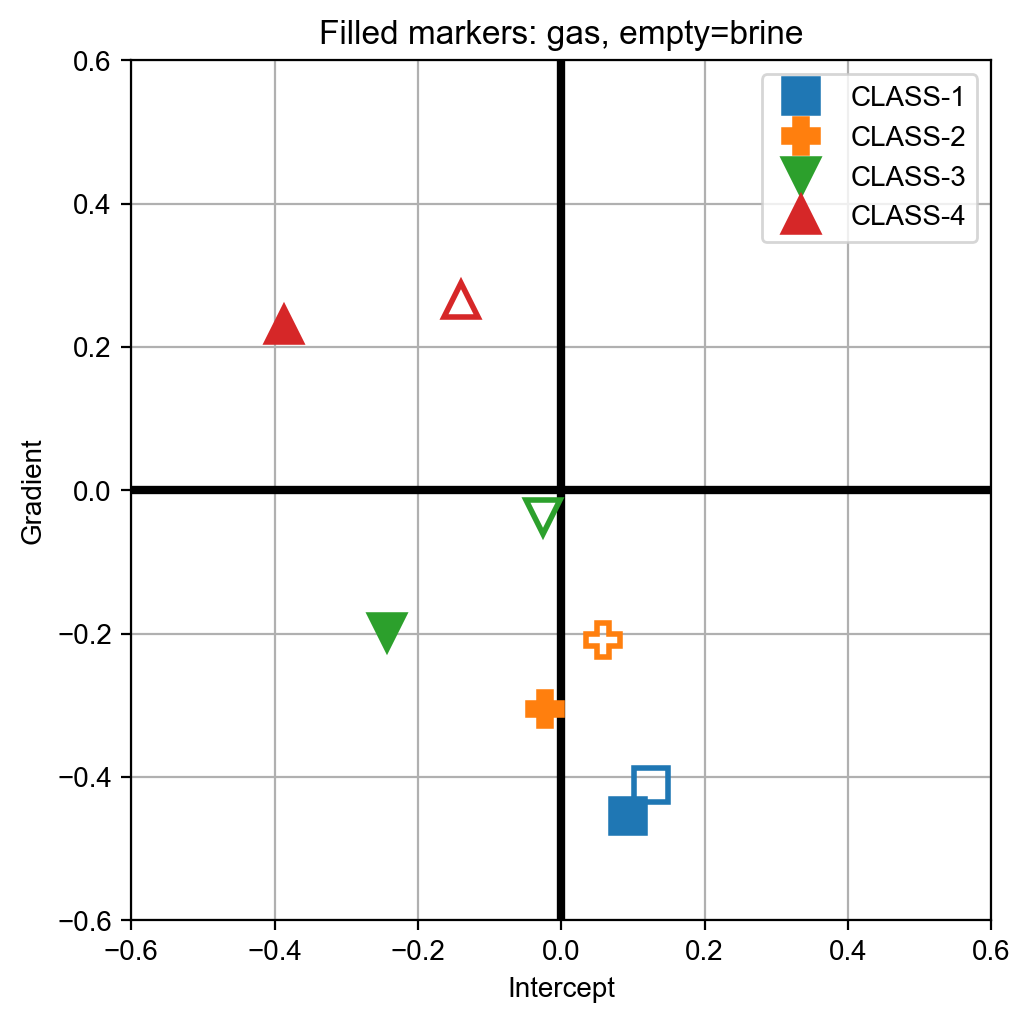

In [34]:
squit.avo.classref(near=5, far=30, plot_brine=True, nearfar=False)

Now I will take the shale data for class 4 and make a gas sand from the brine class-4 sand, then plot the resulting point in the crossplot above to see graphically the difference from the tabulated value (check where the black star falls):

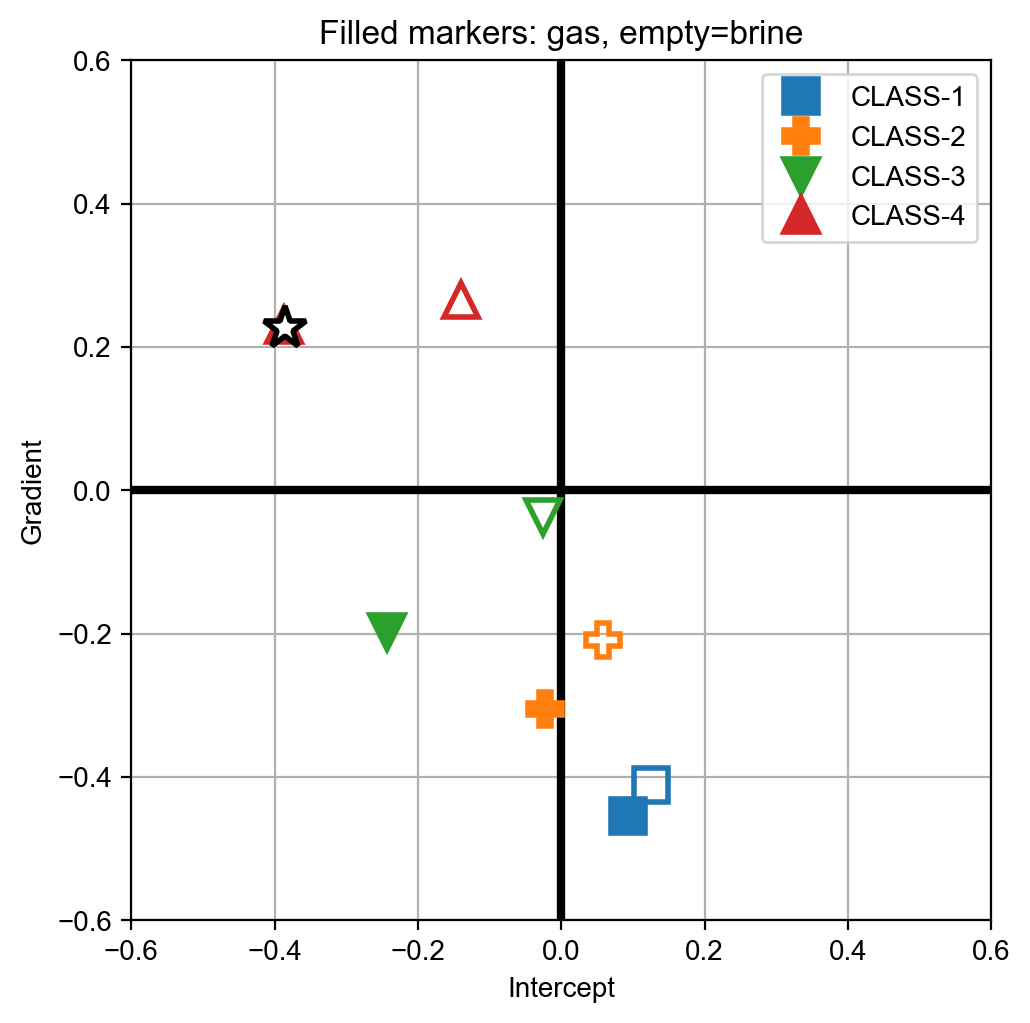

In [35]:
vp0, vs0, rho0 = shale.loc['CLASS-4', ['VP', 'VS', 'RHO']].values
a,b,c,d = sandb.loc['CLASS-4'].values
vp1, vs1, rho1 = toyfrm(a,b,c,d, 'gas', k0=33.65)

squit.avo.classref(near=5, far=30, above=[vp0, vs0, rho0], below=[vp1, vs1, rho1], plot_brine=True, nearfar=False)